In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from pymono.config import CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX

In [5]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [6]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [11]:
from pymono.cnn_func import CNN_basic
from pymono.cnn_func import CNN 

In [13]:
from pymono.cnn_eval import cnn_evaluation, single_run, evaluate_cnn, train_cnn

In [14]:
from pymono.cnn_func import CNN_basic

In [15]:
from pymono.cnn_func import ResNet10

In [16]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [61]:
from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz

In [17]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX

- Study performance of a CsI monolithic crystal.
- Compare Conv and Resnet

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 50 k photons per point (pure CsI, with ~100 k photons/MeV)
- 0MHzDC (Cold CsI, no DC)
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation 

## Setup

In [18]:
imgs, mdata = select_image_and_lbl(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, 9)

Selected files: img = images_25.npy, metdata = metadata_25.csv


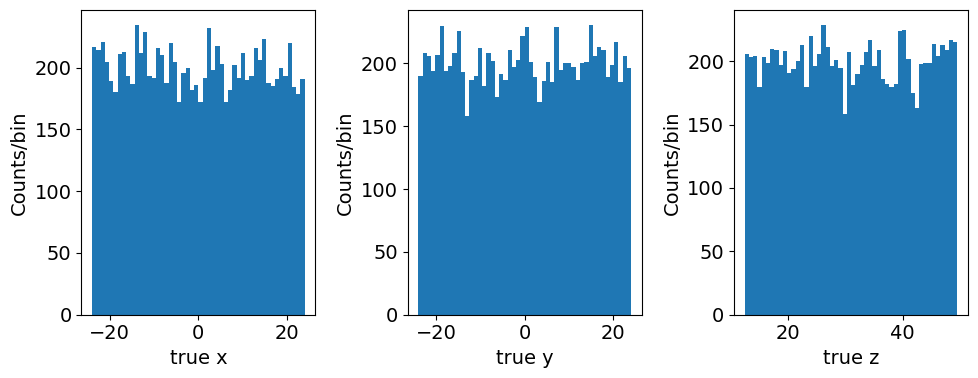

In [19]:
plot_true_positions(mdata)

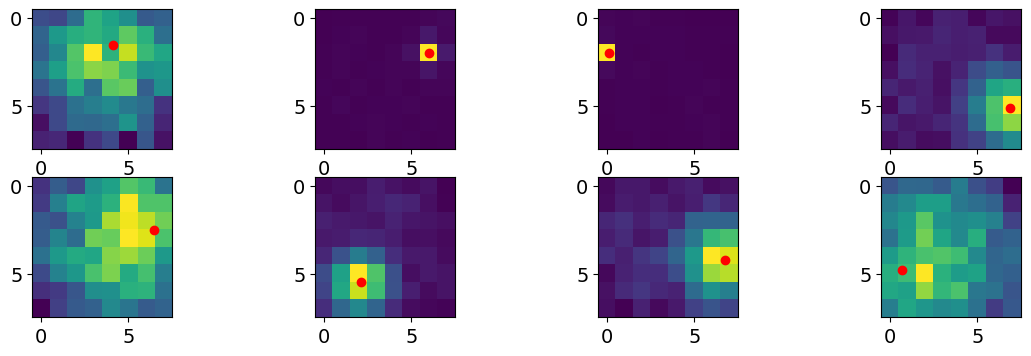

In [20]:
plot_images(imgs, mdata, range(0,8))

In [21]:
imgs[0]

array([[138., 135., 155., 199., 188., 176., 145., 149.],
       [151., 182., 195., 199., 192., 213., 196., 157.],
       [148., 171., 210., 249., 198., 236., 202., 190.],
       [160., 186., 208., 224., 221., 203., 178., 181.],
       [142., 159., 193., 157., 212., 216., 148., 176.],
       [127., 136., 158., 166., 174., 162., 156., 125.],
       [110., 136., 154., 153., 157., 179., 149., 119.],
       [118., 120., 105., 125., 136., 104., 143., 111.]], dtype=float32)

In [22]:
np.mean(imgs[0])

166.57812

In [23]:
np.std(imgs[0])

33.971405

In [24]:
energy = get_energy(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, 9)

Selected files: img = images_25.npy, metdata = metadata_25.csv


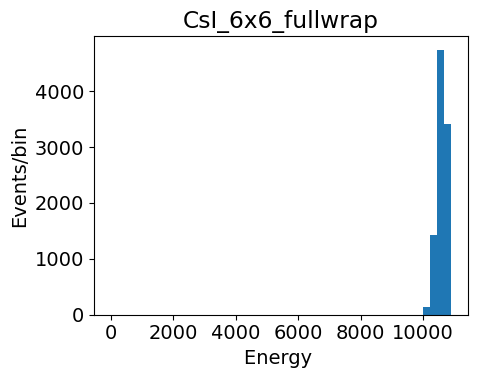

In [25]:
plot_energies2({"CsI_6x6_fullwrap":energy}, xmin=0, xmax=max(energy),num_bins = 50)

In [26]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} resolution (FWHM)  = {100*fwhm6x6:.2f} %")

mean = 10616.38 resolution (FWHM)  = 3.47 %


## Data set

In [27]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [28]:
dataset = MonoDataset(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, first_file, last_file)


Running MonoDataset with norm = False, resize=False, xyze=False
Loading files with indexes: [  1   2   3   4  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100]


In [29]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 840000 events
 train size = 588000
 val size = 168000
 test size = 84000
 train indices = range(0, 588000)
 val indices = range(588000, 756000)
 test indices = range(756000, 840000)
588000 training events (70.0%)
168000 validation events (20.0%)
84000 test events (10.0%)


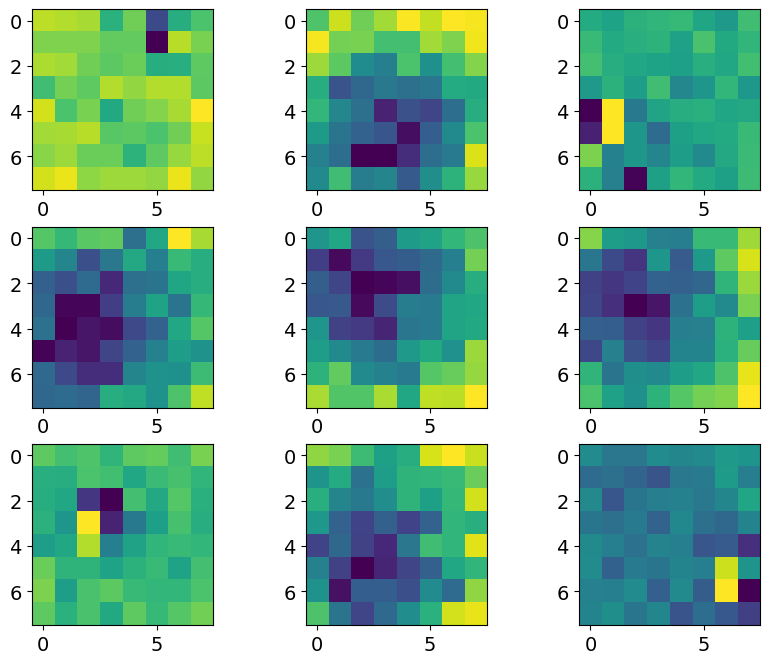

In [30]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [31]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([100, 1, 8, 8])
torch.Size([100, 3])
tensor([[206., 187., 205., 156., 145., 112., 127., 106.],
        [262., 312., 257., 184., 178., 142., 128., 112.],
        [317., 307., 266., 236., 195., 134., 106., 119.],
        [270., 268., 240., 198., 159., 143., 150., 125.],
        [202., 220., 206., 181., 147., 132., 128., 124.],
        [176., 175., 173., 151., 129., 150., 139., 112.],
        [122., 126., 139., 137., 129., 128., 121., 110.],
        [107., 107., 123., 126., 124., 113., 105., 113.]])


### Train the network with CNN_basic 

In [32]:
# Load the model.
model = CNN_basic(dropout=False).to(device)
print(model)

CNN_basic(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [33]:
# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [34]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([100, 1, 8, 8])
labels = torch.Size([100, 3])
input data shape =>torch.Size([100, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([100, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([100, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([100, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([100, 512])
torch.Size([100, 3])
outputs = torch.Size([100, 3])
Train Step 1/5880, Loss: 457.995361328125
i = 1
images = torch.Size([100, 1, 8, 8])
labels = torch.Size([100, 3])
outputs = torch.Size([100, 3])
Train Step 2/5880, Loss: 396.02459716796875


In [35]:
epochs = 15

In [36]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=200)

Training with  ->588000 images
size of train loader  ->5880 images
Evaluating with  ->168000 images
size of eval loader  ->1680 images
Running for epochs ->15

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 6.126956486499228
--- EPOCH 0 AVG VAL LOSS: 4.799059964077813

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 4.478866229535771
--- EPOCH 1 AVG VAL LOSS: 4.093534384029252

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 4.1928657873552675
--- EPOCH 2 AVG VAL LOSS: 4.056487196967716

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 4.0532269428579175
--- EPOCH 3 AVG VAL LOSS: 4.064316110100065

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 3.9472414665278936
--- EPOCH 4 AVG VAL LOSS: 4.137706370580764

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 3.8739173342176034
--- EPOCH 5 AVG VAL LOSS: 3.765880576556637

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 3.8172747420210418
--- EPOCH 6 AVG VAL LOSS: 3.863939395050208

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 3.770891361394707
--- EPOCH 7 AVG VAL LOSS: 3.7369030991480465

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 3.7328

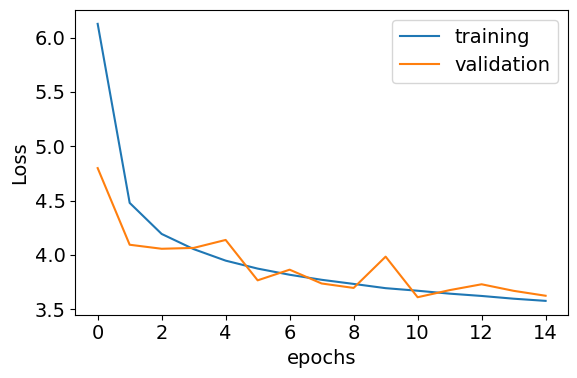

In [37]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))


In [38]:
tdeltas = evaluate_cnn(test_loader, model, device)

In [ ]:
#plot_true_predicted(tdeltas, nbins = 50)

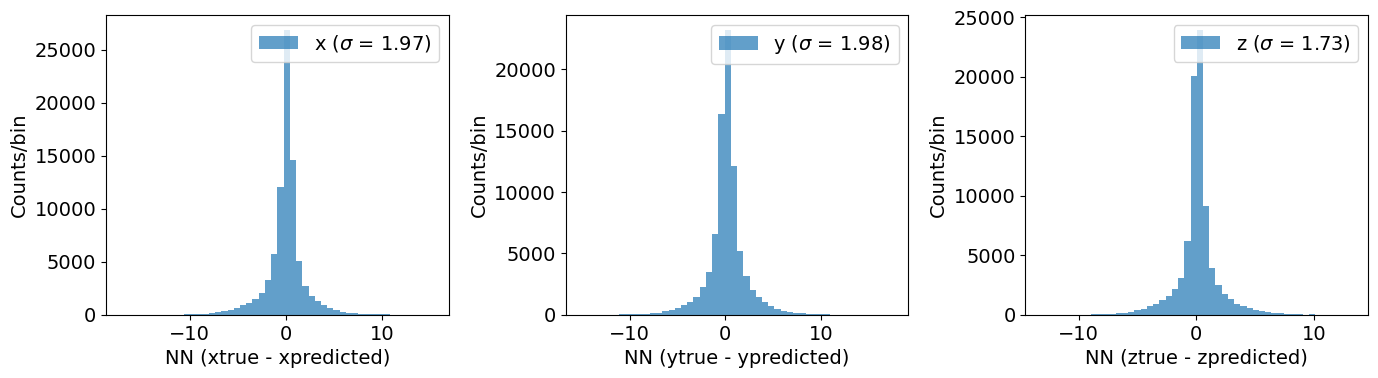

In [39]:
plotxyz(tdeltas, nbins=50)

## Normalize

In [40]:
dataset = MonoDataset(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, 
                      first_file, last_file,
                      norm=True, resize=False, mean=165.90, std=93.3)


Running MonoDataset with norm = True, resize=False, xyze=False
Loading files with indexes: [  1   2   3   4  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100]


In [41]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 840000 events
 train size = 588000
 val size = 168000
 test size = 84000
 train indices = range(0, 588000)
 val indices = range(588000, 756000)
 test indices = range(756000, 840000)
588000 training events (70.0%)
168000 validation events (20.0%)
84000 test events (10.0%)


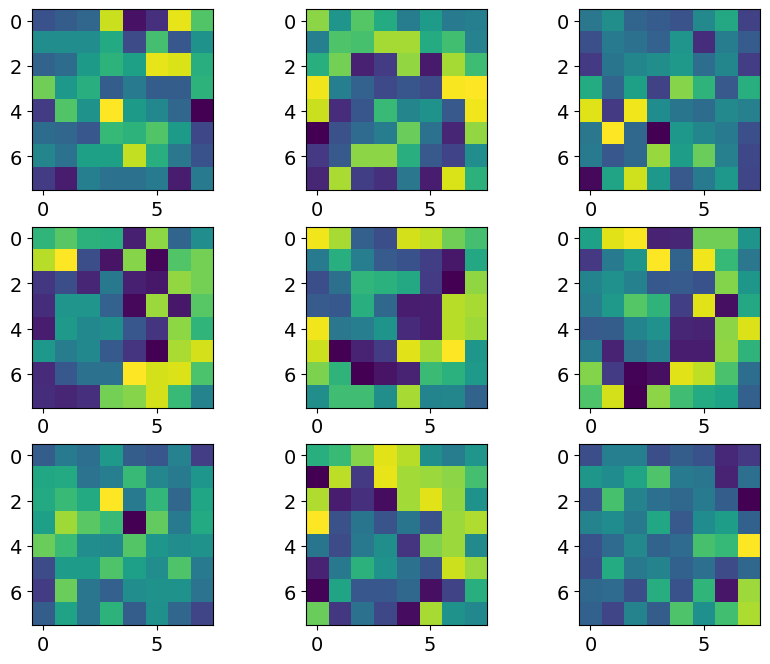

In [42]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [43]:
images, positions = next(iter(train_loader)) 
print(f"read image batch, size->{images.size()}")
img = images[0].squeeze()
print(img)

read image batch, size->torch.Size([100, 1, 8, 8])
tensor([[-0.2240, -0.0418,  0.1404,  0.1083, -0.2990, -0.5134, -0.4384, -0.5027],
        [ 0.0118,  0.7728,  0.7406,  0.3333,  0.0118, -0.2347, -0.4277, -0.5241],
        [ 0.9550,  0.9657,  0.9335,  0.6977,  0.2690,  0.1190, -0.2669, -0.5348],
        [ 0.8049,  1.4695,  1.0729,  0.9871,  0.4727, -0.0847, -0.3312, -0.5348],
        [ 0.4298,  0.9121,  1.0300,  0.5370,  0.1833, -0.3098, -0.4062, -0.5456],
        [ 0.3333,  0.3655,  0.5048,  0.3655, -0.0418, -0.2562, -0.4062, -0.5348],
        [-0.2240,  0.2905,  0.1083, -0.0204, -0.1704, -0.3419, -0.6742, -0.6635],
        [-0.6742, -0.3848, -0.4598, -0.5348, -0.4920, -0.6742, -0.6635, -0.7170]])


In [44]:
model = CNN_basic(dropout=False).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


CNN_basic(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [45]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([100, 1, 8, 8])
labels = torch.Size([100, 3])
input data shape =>torch.Size([100, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([100, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([100, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([100, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([100, 512])
torch.Size([100, 3])
outputs = torch.Size([100, 3])
Train Step 1/5880, Loss: 484.5674743652344
i = 1
images = torch.Size([100, 1, 8, 8])
labels = torch.Size([100, 3])
outputs = torch.Size([100, 3])
Train Step 2/5880, Loss: 351.2481994628906


In [46]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=200)

Training with  ->588000 images
size of train loader  ->5880 images
Evaluating with  ->168000 images
size of eval loader  ->1680 images
Running for epochs ->15

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 5.671703383306257
--- EPOCH 0 AVG VAL LOSS: 4.3009863688832235

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 4.2677661416887425
--- EPOCH 1 AVG VAL LOSS: 3.996573093178726

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 4.003974078707143
--- EPOCH 2 AVG VAL LOSS: 3.9956115052813574

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 3.859573788788854
--- EPOCH 3 AVG VAL LOSS: 3.873685509534109

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 3.762769021712193
--- EPOCH 4 AVG VAL LOSS: 3.7179959995406016

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 3.6955425017950487
--- EPOCH 5 AVG VAL LOSS: 3.667120636928649

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 3.638293241724676
--- EPOCH 6 AVG VAL LOSS: 3.6212941625288555

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 3.590663258680681
--- EPOCH 7 AVG VAL LOSS: 3.649270655498618

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 3.5584

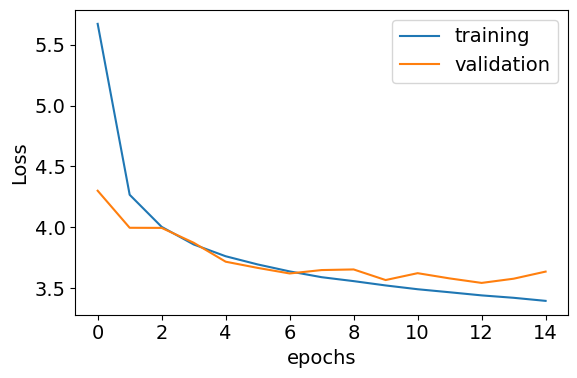

In [47]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))



In [48]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6)

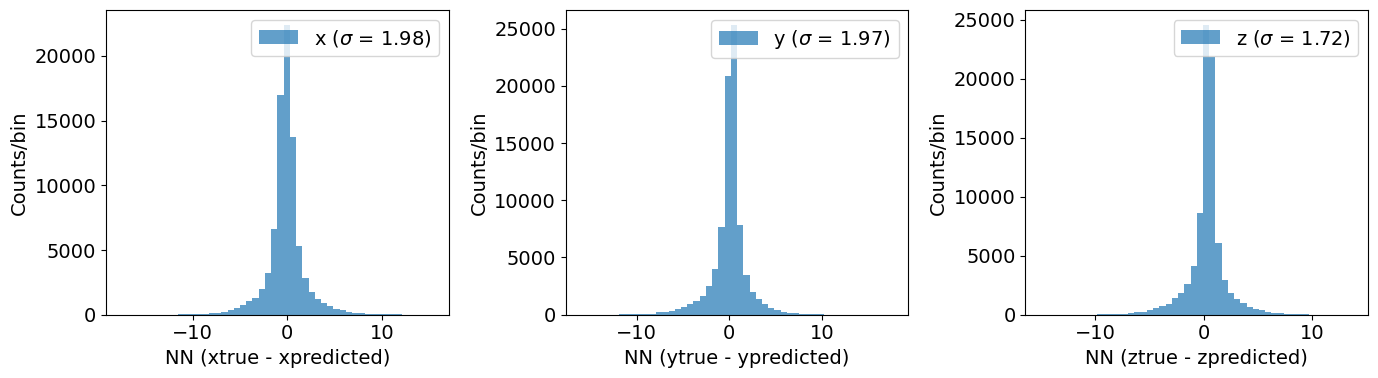

In [49]:
plotxyz(tdeltas, nbins=50)

### Deeper network

In [50]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [51]:
class ResNet10(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image passes through a convolution (kernel 3x3) 
    with stride = 1 and padding = 1 which increases the features from 3 to 64 and 
    preserves spatian dimensions, then batch normalization and activation. 
    # (W,H,1) => (W,H,64)
    
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, num_classes = 3, dropout=False, dropout_fraction=0.2, debug=False):
        super(ResNet10, self).__init__()
        self.debug = debug
        self.inplanes = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, 2)
        self.layer0 = self._make_layer(block, 64, 1, stride = 1, nlyr = 1)
        self.layer1 = self._make_layer(block, 128, 1, stride = 2, nlyr = 2)
        self.layer2 = self._make_layer(block, 256, 1, stride = 2, nlyr = 3)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2, nlyr = 4)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)

           
    def _make_layer(self, block, planes, blocks, stride, nlyr):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer {nlyr}: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            #print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    def forward(self, x):
        if(self.debug): print(f" ResNet10: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet10: after conv1 =>{x.shape}")
            
        #x = self.maxpool(x)
        #if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet10: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet10: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet10: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet10: after layer3 =>{x.shape}")
            
        x = self.avgpool(x)
        if(self.debug): print(f" ResNet10: after avgpool =>{x.shape}")

        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet10: after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc(x)
        if(self.debug): print(f" ResNet10: after fc =>{x.shape}")

        self.debug = False
        return x
  

In [52]:
#define the model
model = ResNet10(ResBlock, debug=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [53]:
print(model)

ResNet10(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-0

In [54]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [55]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([100, 1, 8, 8])
labels = torch.Size([100, 3])
 ResNet10: input data shape =>torch.Size([100, 1, 8, 8])
 ResNet10: after conv1 =>torch.Size([100, 64, 8, 8])
 ResNet10: after layer0 =>torch.Size([100, 64, 8, 8])
 ResNet10: after layer1 =>torch.Size([100, 128, 4, 4])
 ResNet10: after layer2 =>torch.Size([100, 256, 2, 2])
 ResNet10: after layer3 =>torch.Size([100, 512, 1, 1])
 ResNet10: after avgpool =>torch.Size([100, 512, 1, 1])
 ResNet10: after flatten =>torch.Size([100, 512])
 ResNet10: after fc =>torch.Size([100, 3])
outputs = torch.Size([100, 3])
Train Step 1/5880, Loss: 511.6510009765625
i = 1
images = torch.Size([100, 1, 8, 8])
labels = torch.Size([100, 3])
outputs = torch.Size([100, 3])
Train Step 2/5880, Loss: 447.5767822265625


In [56]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size=500, epochs=10, iprnt=200)

Training with  ->2940000 images
size of train loader  ->5880 images
Evaluating with  ->840000 images
size of eval loader  ->1680 images
Running for epochs ->10

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 6.627093589670804
--- EPOCH 0 AVG VAL LOSS: 3.9648850297644023

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 4.098040532660322
--- EPOCH 1 AVG VAL LOSS: 3.794909655976863

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 3.828043641646703
--- EPOCH 2 AVG VAL LOSS: 3.618885880353905

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 3.692562751178028
--- EPOCH 3 AVG VAL LOSS: 3.6595780669933275

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 3.596150942805673
--- EPOCH 4 AVG VAL LOSS: 3.4801113134338744

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 3.532185452750751
--- EPOCH 5 AVG VAL LOSS: 3.5335141704196023

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 3.477155826083657
--- EPOCH 6 AVG VAL LOSS: 3.4029998239307178

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 3.43021495399021
--- EPOCH 7 AVG VAL LOSS: 3.4366301366261074

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 3.3868

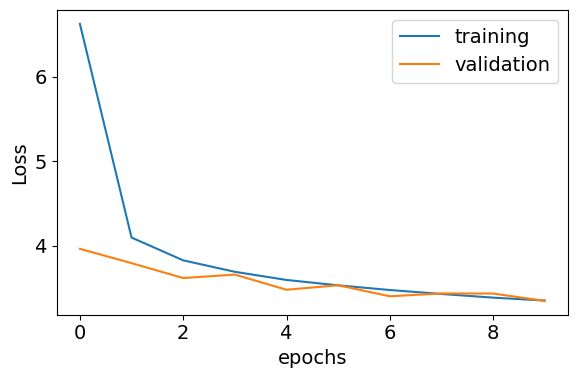

In [57]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))


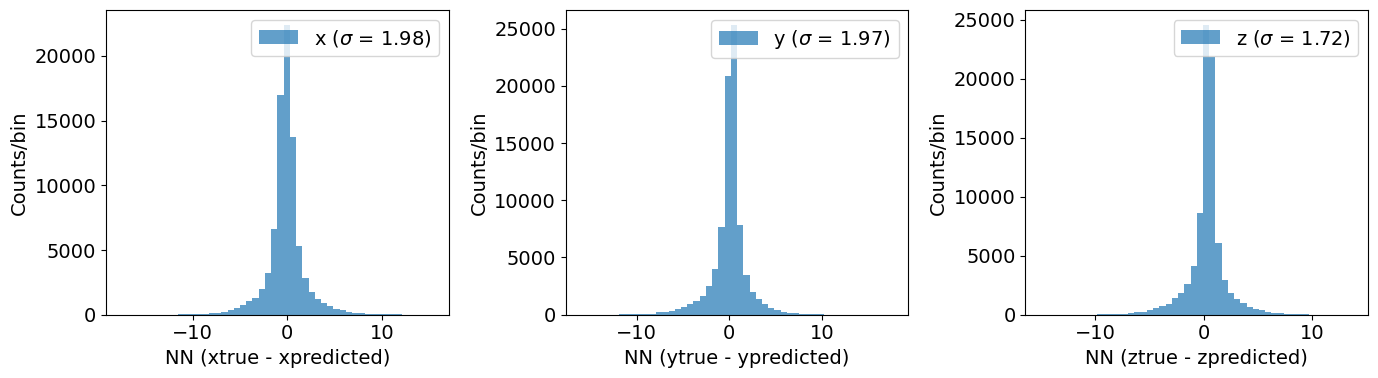

In [58]:
plotxyz(tdeltas, nbins=50)

In [62]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = 0.47, sigma = 0.37, n1  =0.83
2g fit: mu2 = 0.23, sigma = 1.74, n1  =0.17
weighted error: = 0.60
2g fit: mu1 = -0.16, sigma = 0.65, n1  =0.85
2g fit: mu2 = -0.14, sigma = 2.51, n1  =0.15
weighted error: = 0.93
2g fit: mu1 = 0.25, sigma = 0.38, n1  =0.78
2g fit: mu2 = 0.04, sigma = 1.67, n1  =0.22
weighted error: = 0.67


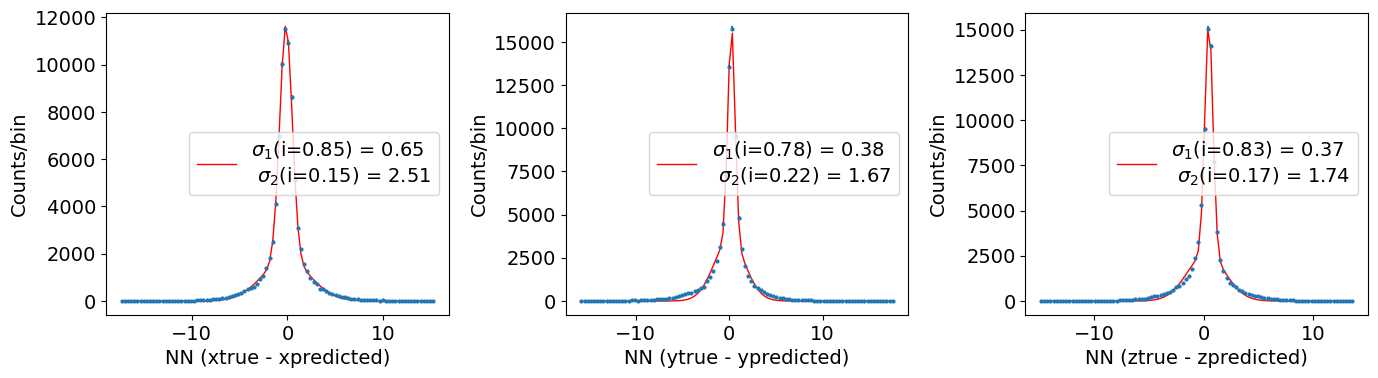

In [65]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4), savefig=True, figname="CsiSigmaxyz.png")

## Calculation of means

In [66]:
means, stds = get_means_stds(dir=CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX)

files in dir: 84
shape -> (10000, 8, 8)
mean img0 =166.796875
std  img0 =382.7119445800781


In [67]:
len(means)

84

In [68]:
means[0][0]

166.79688

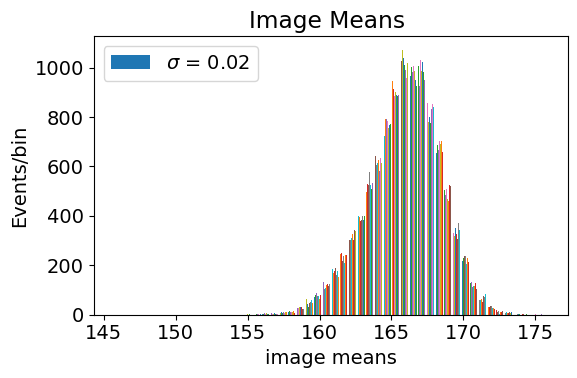

In [69]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

In [70]:
meansx =[np.mean(x) for x in means]

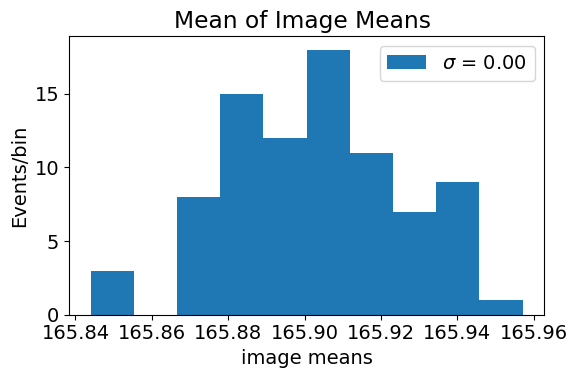

In [71]:
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [72]:
np.mean(meansx)

165.90295

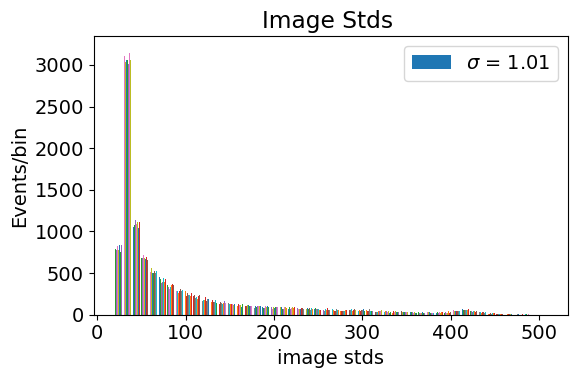

In [73]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

In [74]:
stdsx =[np.std(x) for x in stds]

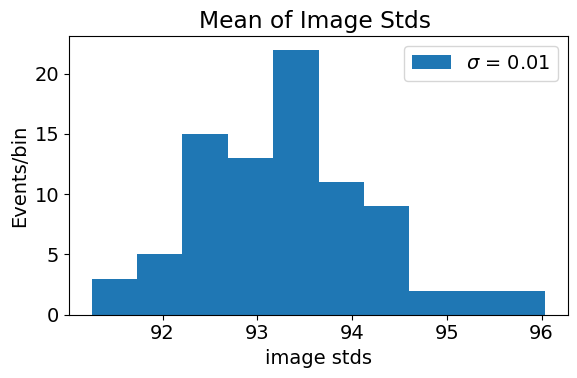

In [75]:
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [76]:
np.mean(stdsx)

93.342735